In [1]:
#coding=utf-8
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
from tqdm import tqdm

from torch import optim
from time import gmtime, strftime
from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

from config import input_size, root, proposalN, channels
from utils.read_dataset import read_dataset
from utils.auto_laod_resume import auto_load_resume
from utils.utils import TrainClock, save_args, AverageMeter, AUCMeter,calculate_accuracy
from networks.model import MainNet

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")

In [3]:
# dataset
set = 'Mura'
if set == 'CUB':
    root = './datasets/CUB_200_2011'  # dataset path
    # model path
    pth_path = "./models/cub_epoch144.pth"
    num_classes = 200
elif set == 'Aircraft':
    root = './datasets/FGVC-aircraft'  # dataset path
    # model path
    pth_path = "./models/air_epoch146.pth"
    num_classes = 100
elif set == 'Mura':
    root = r'E:\Xing\Data\MURA-v1.1'  # dataset path
    pth_path = r'C:\Users\Xing\Projects\AirGo\MMAL-Net\checkpoint\mura\epoch48.pth'
    num_classes = 1

batch_size = 1

#load dataset
_, testloader = read_dataset(input_size, batch_size, root, set)

Loading Mura
Loading testset


In [4]:
# 定义模型
model = MainNet(proposalN=proposalN, num_classes=num_classes, channels=channels)

model = model.to(DEVICE)

#加载checkpoint
if os.path.exists(pth_path):
    epoch = auto_load_resume(model, pth_path, status='test')
else:
    sys.exit('There is not a pth exist.')

Load model from C:\Users\Xing\Projects\AirGo\MMAL-Net\checkpoint\mura\epoch48.pth
Resume from C:\Users\Xing\Projects\AirGo\MMAL-Net\checkpoint\mura\epoch48.pth


In [5]:
criterion = nn.BCELoss()

In [7]:
# torch.cuda.set_device(3)
# from utils import calculate_accuracy

losses_val = AverageMeter('loss')
accuracies_val = AverageMeter('acc')
model.eval()
y = []
pred = []

#fileio.maybe_make_new_dir(result_path)
with torch.no_grad():
    for i, data in tqdm(enumerate(testloader)):
        
        if set == 'CUB':
            x, label, boxes, _ = data
        else:
            x, label = data
        image_val = x.to(DEVICE)
        targets_val = label.float().to(DEVICE)
        outputs_logits, local_imgs = model(image_val, epoch, i, 'test', DEVICE)[-2:]
        outputs_val = F.sigmoid(outputs_logits)
        
        print(targets_val.shape,outputs_val.shape)
        
#         targets_val = data['label'].float().cuda()
#         images_val = data['image'].float().cuda()
#         outputs_val = model(images_val)
        loss_val = criterion(outputs_val, targets_val)
        
#         add_gl_image_index(images_val, patches_val, outputs_val, targets_val,  writer, subset='val', epoch=0, index = j)
        
        acc_val = calculate_accuracy(outputs_val, targets_val)
        losses_val.update(loss_val.item(), targets_val.size(0))
        accuracies_val.update(acc_val, targets_val.size(0))
        y.append(targets_val.cpu().numpy())
        pred.append(outputs_val.cpu().numpy())

print('val_loss: ', losses_val.avg, 'val_acc: ', accuracies_val.avg)


3it [00:00, 10.99it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

7it [00:00, 13.63it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


11it [00:00, 15.46it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


15it [00:00, 15.52it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


17it [00:01, 15.41it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

21it [00:01, 15.41it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

23it [00:01, 15.44it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

27it [00:01, 15.53it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

31it [00:01, 16.33it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


35it [00:02, 16.75it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


37it [00:02, 16.13it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

41it [00:02, 16.21it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

45it [00:02, 16.80it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


47it [00:02, 16.81it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

51it [00:03, 16.33it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

53it [00:03, 15.96it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

57it [00:03, 16.32it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

59it [00:03, 16.15it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

63it [00:03, 15.82it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

65it [00:04, 15.81it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

69it [00:04, 16.12it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


73it [00:04, 16.33it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

75it [00:04, 16.31it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

79it [00:04, 16.38it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

81it [00:05, 16.31it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

85it [00:05, 15.51it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


87it [00:05, 15.23it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


91it [00:05, 15.31it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


93it [00:05, 15.06it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

97it [00:06, 16.10it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


101it [00:06, 15.82it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


103it [00:06, 15.19it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

107it [00:06, 15.52it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

109it [00:06, 15.49it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

113it [00:07, 15.66it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


117it [00:07, 16.02it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


121it [00:07, 16.94it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


123it [00:07, 16.95it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

127it [00:07, 15.89it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

129it [00:08, 16.20it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

133it [00:08, 15.89it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

135it [00:08, 16.04it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

139it [00:08, 15.96it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

143it [00:08, 16.50it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


145it [00:09, 17.11it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

149it [00:09, 15.92it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

151it [00:09, 15.80it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

155it [00:09, 15.64it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

157it [00:09, 15.07it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

161it [00:10, 15.27it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


163it [00:10, 14.87it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

167it [00:10, 15.13it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


169it [00:10, 15.04it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

173it [00:10, 14.64it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

175it [00:11, 14.70it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

179it [00:11, 14.84it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

181it [00:11, 14.67it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

185it [00:11, 15.35it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

187it [00:11, 15.40it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


191it [00:12, 14.24it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

193it [00:12, 15.24it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

197it [00:12, 15.66it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

199it [00:12, 15.91it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

203it [00:12, 15.22it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

205it [00:13, 15.21it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

209it [00:13, 15.18it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

211it [00:13, 14.97it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

215it [00:13, 16.10it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


219it [00:13, 16.05it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


223it [00:14, 15.92it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

225it [00:14, 15.61it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


229it [00:14, 15.18it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

231it [00:14, 14.77it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


235it [00:14, 14.90it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

237it [00:15, 14.28it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


241it [00:15, 14.42it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

243it [00:15, 15.13it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

247it [00:15, 15.73it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

249it [00:15, 15.10it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

253it [00:16, 16.00it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

255it [00:16, 15.78it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

259it [00:16, 15.53it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

261it [00:16, 15.53it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

265it [00:16, 15.70it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

267it [00:17, 15.29it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

271it [00:17, 15.21it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

273it [00:17, 15.45it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


277it [00:17, 15.06it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

279it [00:17, 15.33it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

283it [00:18, 15.10it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

287it [00:18, 15.81it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


289it [00:18, 15.18it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

293it [00:18, 15.44it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

295it [00:18, 15.32it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

299it [00:19, 14.41it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


301it [00:19, 14.92it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

305it [00:19, 15.29it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

307it [00:19, 14.95it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

311it [00:19, 15.59it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

313it [00:20, 15.50it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


317it [00:20, 14.90it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

319it [00:20, 15.32it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

323it [00:20, 16.03it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

325it [00:20, 15.65it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

329it [00:21, 15.82it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

331it [00:21, 15.22it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


335it [00:21, 15.67it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


339it [00:21, 16.61it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

341it [00:21, 16.43it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


345it [00:22, 14.57it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


347it [00:22, 14.74it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

351it [00:22, 14.92it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

353it [00:22, 15.52it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

357it [00:22, 15.42it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

359it [00:23, 15.55it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

363it [00:23, 14.91it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

365it [00:23, 15.44it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

369it [00:23, 15.55it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

373it [00:23, 15.61it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


375it [00:24, 15.41it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

379it [00:24, 15.43it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


383it [00:24, 15.61it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

385it [00:24, 16.19it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


389it [00:24, 15.44it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

391it [00:25, 15.11it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


395it [00:25, 15.01it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

397it [00:25, 15.51it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

401it [00:25, 16.50it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


405it [00:26, 15.85it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

407it [00:26, 15.67it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

411it [00:26, 14.80it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

413it [00:26, 14.58it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


417it [00:26, 14.86it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

419it [00:26, 14.95it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

423it [00:27, 15.30it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

427it [00:27, 15.92it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


429it [00:27, 16.06it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


433it [00:27, 15.11it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

437it [00:28, 16.06it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

439it [00:28, 15.74it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

443it [00:28, 16.11it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


447it [00:28, 16.25it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


449it [00:28, 14.68it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

453it [00:29, 14.77it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

455it [00:29, 15.09it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

459it [00:29, 15.69it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

463it [00:29, 16.74it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


465it [00:29, 16.60it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

469it [00:30, 15.73it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

471it [00:30, 15.89it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

475it [00:30, 16.49it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


479it [00:30, 16.00it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

481it [00:30, 15.82it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

485it [00:31, 14.96it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

489it [00:31, 16.01it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


491it [00:31, 15.67it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

495it [00:31, 16.06it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


499it [00:32, 15.90it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

501it [00:32, 15.90it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


505it [00:32, 15.48it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

509it [00:32, 16.19it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


513it [00:32, 16.73it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


515it [00:32, 16.97it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

519it [00:33, 16.20it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

521it [00:33, 16.15it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

525it [00:33, 15.22it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

527it [00:33, 15.82it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

531it [00:34, 15.83it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

535it [00:34, 16.55it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


537it [00:34, 16.88it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

541it [00:34, 16.51it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

543it [00:34, 15.71it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

547it [00:35, 16.07it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

551it [00:35, 16.48it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


553it [00:35, 15.95it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


557it [00:35, 16.07it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


561it [00:35, 16.26it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

563it [00:35, 15.91it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

567it [00:36, 15.88it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) 

569it [00:36, 15.66it/s]

torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

573it [00:36, 15.40it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

575it [00:36, 14.95it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

579it [00:37, 15.16it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

583it [00:37, 15.95it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


587it [00:37, 16.54it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


589it [00:37, 15.69it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


593it [00:37, 15.57it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

595it [00:38, 14.93it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

599it [00:38, 16.03it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


603it [00:38, 16.08it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

605it [00:38, 15.87it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

609it [00:38, 15.68it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

611it [00:39, 15.70it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


615it [00:39, 15.53it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

617it [00:39, 15.46it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

621it [00:39, 15.50it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

625it [00:39, 16.56it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


627it [00:40, 16.16it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

631it [00:40, 16.15it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


635it [00:40, 15.58it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

637it [00:40, 15.82it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

641it [00:41, 14.59it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


643it [00:41, 15.16it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


647it [00:41, 15.28it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

649it [00:41, 15.75it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


653it [00:41, 15.94it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

657it [00:41, 16.18it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

659it [00:42, 16.01it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

663it [00:42, 15.53it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

665it [00:42, 15.38it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

669it [00:42, 15.97it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

673it [00:42, 16.89it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

675it [00:43, 16.87it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

679it [00:43, 16.15it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

681it [00:43, 16.27it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

685it [00:43, 16.37it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


689it [00:43, 16.07it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

691it [00:44, 15.79it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

695it [00:44, 15.81it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


699it [00:44, 17.03it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


703it [00:44, 16.53it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


707it [00:45, 16.15it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

709it [00:45, 15.58it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

713it [00:45, 14.81it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

715it [00:45, 15.01it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

719it [00:45, 15.15it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

721it [00:46, 15.61it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

725it [00:46, 15.25it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

727it [00:46, 16.03it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

731it [00:46, 15.99it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

733it [00:46, 15.30it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

737it [00:47, 15.55it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

739it [00:47, 15.69it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

743it [00:47, 15.92it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


747it [00:47, 15.85it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

749it [00:47, 16.02it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

753it [00:48, 15.78it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


755it [00:48, 15.63it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

759it [00:48, 14.73it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

761it [00:48, 14.99it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

765it [00:48, 15.43it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


769it [00:49, 15.85it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

771it [00:49, 16.01it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

775it [00:49, 16.26it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


779it [00:49, 16.29it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

781it [00:49, 16.05it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

785it [00:50, 16.76it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


789it [00:50, 17.19it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


793it [00:50, 15.83it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


797it [00:50, 16.23it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


801it [00:51, 16.50it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


803it [00:51, 16.43it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

807it [00:51, 16.52it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


811it [00:51, 16.37it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

813it [00:51, 16.46it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

817it [00:52, 15.89it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

819it [00:52, 16.28it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

823it [00:52, 15.67it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

825it [00:52, 15.81it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

829it [00:52, 15.04it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

833it [00:53, 15.81it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


835it [00:53, 16.10it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


841it [00:53, 16.73it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


843it [00:53, 16.68it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

847it [00:53, 16.89it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


851it [00:54, 17.02it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

855it [00:54, 17.23it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


859it [00:54, 17.31it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


863it [00:54, 17.63it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


865it [00:54, 17.07it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

869it [00:55, 16.07it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

873it [00:55, 16.40it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


875it [00:55, 15.82it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

879it [00:55, 16.58it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) 

883it [00:56, 16.52it/s]

torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


885it [00:56, 16.33it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

889it [00:56, 15.99it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

891it [00:56, 16.12it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

895it [00:56, 16.37it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


899it [00:57, 16.70it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


903it [00:57, 16.72it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

907it [00:57, 16.63it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


909it [00:57, 16.77it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

913it [00:57, 16.13it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

915it [00:57, 16.74it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

919it [00:58, 15.75it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

921it [00:58, 15.28it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

925it [00:58, 15.78it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


929it [00:58, 15.93it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


933it [00:59, 16.52it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

935it [00:59, 16.09it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

939it [00:59, 15.76it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

941it [00:59, 15.58it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

945it [00:59, 15.60it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

947it [00:59, 15.80it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

951it [01:00, 15.20it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


955it [01:00, 16.07it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

957it [01:00, 16.37it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


961it [01:00, 16.07it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


965it [01:01, 15.81it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

967it [01:01, 15.50it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

971it [01:01, 15.35it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

973it [01:01, 15.51it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

977it [01:01, 14.87it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


979it [01:02, 14.99it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

983it [01:02, 15.69it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

985it [01:02, 15.57it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

989it [01:02, 15.73it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

993it [01:02, 15.93it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


995it [01:03, 15.54it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

999it [01:03, 16.28it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1003it [01:03, 15.84it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1005it [01:03, 15.28it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1009it [01:03, 15.47it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1011it [01:04, 15.00it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1015it [01:04, 15.79it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1019it [01:04, 15.95it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1023it [01:04, 16.37it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1027it [01:05, 16.74it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1029it [01:05, 16.52it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1033it [01:05, 16.68it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1037it [01:05, 16.28it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1039it [01:05, 16.05it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1043it [01:06, 13.21it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1045it [01:06, 13.44it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1049it [01:06, 14.11it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1053it [01:06, 15.03it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1055it [01:06, 15.46it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1059it [01:07, 16.42it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1063it [01:07, 17.29it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1067it [01:07, 16.12it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1069it [01:07, 15.35it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1073it [01:08, 15.82it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1077it [01:08, 16.38it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1081it [01:08, 16.85it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1085it [01:08, 16.95it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1087it [01:08, 16.70it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1091it [01:09, 16.44it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1093it [01:09, 16.39it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1097it [01:09, 16.17it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1099it [01:09, 15.52it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1103it [01:09, 16.24it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1107it [01:10, 16.07it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1109it [01:10, 15.49it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1113it [01:10, 14.67it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1115it [01:10, 15.51it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1119it [01:10, 15.64it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1121it [01:11, 15.04it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1123it [01:11, 12.39it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1127it [01:11, 13.81it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1129it [01:11, 14.16it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1133it [01:11, 14.94it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1137it [01:12, 15.84it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1139it [01:12, 16.32it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1143it [01:12, 15.95it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1145it [01:12, 16.01it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) 

1149it [01:12, 15.49it/s]

torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1151it [01:13, 15.68it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1155it [01:13, 15.90it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1157it [01:13, 15.71it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1161it [01:13, 15.66it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1163it [01:13, 15.69it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1167it [01:14, 15.78it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1169it [01:14, 15.89it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1173it [01:14, 16.23it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1177it [01:14, 16.38it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1181it [01:14, 15.86it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1183it [01:15, 15.99it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1185it [01:15, 15.06it/s]

 torch.Size([1, 1])


1187it [01:15, 10.90it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1191it [01:15, 13.17it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1195it [01:16, 13.99it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1197it [01:16, 14.36it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1201it [01:16, 15.29it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1203it [01:16, 14.88it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1207it [01:16, 14.45it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1209it [01:16, 14.47it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1213it [01:17, 15.04it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1217it [01:17, 16.11it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1219it [01:17, 15.17it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1223it [01:17, 15.16it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1225it [01:17, 15.37it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1229it [01:18, 15.98it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1233it [01:18, 16.61it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1237it [01:18, 16.64it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1241it [01:18, 16.20it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1243it [01:19, 15.80it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1247it [01:19, 15.89it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1249it [01:19, 16.08it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1253it [01:19, 16.42it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1257it [01:19, 15.80it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1259it [01:20, 16.41it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1263it [01:20, 16.31it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1267it [01:20, 16.93it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1269it [01:20, 17.47it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1273it [01:20, 16.36it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1277it [01:21, 16.49it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1279it [01:21, 16.80it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1283it [01:21, 15.35it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1285it [01:21, 15.88it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1289it [01:21, 15.51it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1293it [01:22, 15.07it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1295it [01:22, 14.63it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1299it [01:22, 15.01it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1301it [01:22, 15.02it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1305it [01:23, 14.79it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1307it [01:23, 14.54it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1311it [01:23, 14.53it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1315it [01:23, 15.73it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1319it [01:23, 16.31it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1321it [01:24, 16.30it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1325it [01:24, 16.44it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1329it [01:24, 16.59it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1333it [01:24, 17.58it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1337it [01:24, 17.67it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1341it [01:25, 16.49it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1343it [01:25, 15.51it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1347it [01:25, 14.78it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1351it [01:25, 15.52it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1355it [01:26, 15.93it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1357it [01:26, 15.37it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1361it [01:26, 16.03it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1365it [01:26, 16.36it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1369it [01:26, 16.95it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1373it [01:27, 16.41it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1375it [01:27, 16.45it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1379it [01:27, 16.54it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1383it [01:27, 17.26it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1387it [01:28, 17.22it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1389it [01:28, 16.11it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1393it [01:28, 14.54it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1395it [01:28, 14.53it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1399it [01:28, 15.48it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1401it [01:29, 15.04it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1405it [01:29, 15.91it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1409it [01:29, 16.76it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1413it [01:29, 16.82it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1417it [01:29, 17.22it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1421it [01:30, 15.91it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1425it [01:30, 16.41it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1427it [01:30, 15.53it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1431it [01:30, 15.39it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1433it [01:31, 15.22it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1437it [01:31, 15.74it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1441it [01:31, 16.76it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1445it [01:31, 17.32it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1449it [01:31, 16.70it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1453it [01:32, 17.35it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1457it [01:32, 17.10it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1459it [01:32, 16.88it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1463it [01:32, 16.32it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1467it [01:33, 16.64it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1471it [01:33, 17.31it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1475it [01:33, 17.21it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1479it [01:33, 17.37it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1483it [01:33, 17.49it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1487it [01:34, 17.00it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1489it [01:34, 16.65it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1493it [01:34, 16.92it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1497it [01:34, 17.37it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1501it [01:35, 17.19it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1505it [01:35, 16.72it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1509it [01:35, 17.06it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1513it [01:35, 16.99it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1517it [01:35, 16.95it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1519it [01:36, 17.18it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1523it [01:36, 15.62it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1525it [01:36, 15.74it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1529it [01:36, 15.80it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1533it [01:36, 15.91it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1535it [01:37, 16.25it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1539it [01:37, 16.04it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1543it [01:37, 16.15it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1545it [01:37, 15.41it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1549it [01:37, 15.89it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1553it [01:38, 16.41it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1555it [01:38, 15.90it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1559it [01:38, 15.90it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1563it [01:38, 16.68it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1565it [01:38, 16.48it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1569it [01:39, 16.87it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1573it [01:39, 16.48it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1577it [01:39, 16.58it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1581it [01:39, 16.45it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1583it [01:40, 14.90it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1587it [01:40, 15.71it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1591it [01:40, 16.09it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1593it [01:40, 15.92it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1597it [01:40, 15.47it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1601it [01:41, 15.99it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1603it [01:41, 16.19it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1607it [01:41, 14.97it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1609it [01:41, 14.83it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1613it [01:42, 14.99it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1615it [01:42, 15.25it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1619it [01:42, 15.38it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1621it [01:42, 15.11it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1625it [01:42, 15.67it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1629it [01:43, 16.27it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1633it [01:43, 16.86it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1637it [01:43, 17.10it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1639it [01:43, 16.72it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1643it [01:43, 15.57it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1645it [01:43, 16.24it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1649it [01:44, 16.52it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1653it [01:44, 16.58it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1655it [01:44, 16.25it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1659it [01:44, 14.96it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1661it [01:44, 15.73it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1665it [01:45, 16.26it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1669it [01:45, 17.20it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1673it [01:45, 16.40it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1675it [01:45, 15.82it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1679it [01:46, 16.48it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1683it [01:46, 16.18it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1685it [01:46, 15.46it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1689it [01:46, 15.73it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1693it [01:46, 16.26it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1697it [01:47, 16.83it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1699it [01:47, 16.17it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1703it [01:47, 16.59it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1707it [01:47, 16.79it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1711it [01:48, 17.43it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1715it [01:48, 17.35it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1719it [01:48, 15.81it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1721it [01:48, 15.18it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1725it [01:48, 14.38it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1727it [01:49, 15.03it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1731it [01:49, 16.19it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1735it [01:49, 16.78it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1739it [01:49, 17.14it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1743it [01:49, 17.30it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1747it [01:50, 15.56it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1749it [01:50, 15.26it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1753it [01:50, 15.99it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1757it [01:50, 16.53it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1761it [01:51, 16.85it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1763it [01:51, 16.59it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1767it [01:51, 16.54it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1769it [01:51, 14.10it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1773it [01:51, 14.18it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1775it [01:52, 13.95it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1779it [01:52, 15.32it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1781it [01:52, 14.02it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1785it [01:52, 15.83it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1789it [01:53, 15.40it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1791it [01:53, 15.06it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1795it [01:53, 16.40it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1799it [01:53, 16.24it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1801it [01:53, 16.58it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1805it [01:53, 15.94it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1809it [01:54, 16.53it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1813it [01:54, 16.78it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1815it [01:54, 16.07it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1819it [01:54, 16.43it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1823it [01:55, 16.94it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1827it [01:55, 16.86it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1831it [01:55, 17.97it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1835it [01:55, 17.68it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1839it [01:55, 16.93it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1841it [01:56, 16.90it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1845it [01:56, 16.30it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1849it [01:56, 16.97it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1853it [01:56, 16.61it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1855it [01:56, 16.03it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1859it [01:57, 14.92it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1861it [01:57, 15.48it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1865it [01:57, 16.32it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1869it [01:57, 14.86it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1873it [01:58, 15.57it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1875it [01:58, 15.70it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1879it [01:58, 16.16it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1883it [01:58, 16.52it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1885it [01:58, 15.63it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1889it [01:59, 15.82it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1893it [01:59, 16.54it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1897it [01:59, 17.34it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1899it [01:59, 16.79it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1903it [01:59, 17.11it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1907it [02:00, 16.93it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1911it [02:00, 15.54it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1915it [02:00, 16.04it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1917it [02:00, 15.51it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1921it [02:01, 15.97it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1925it [02:01, 16.93it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1929it [02:01, 16.62it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1933it [02:01, 17.05it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1937it [02:02, 17.47it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1941it [02:02, 16.72it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1943it [02:02, 16.54it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1947it [02:02, 16.11it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1951it [02:02, 16.86it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1953it [02:02, 16.76it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1957it [02:03, 16.98it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1961it [02:03, 17.13it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1963it [02:03, 16.17it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1967it [02:03, 16.08it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1971it [02:04, 16.72it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1975it [02:04, 17.71it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1977it [02:04, 17.71it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1981it [02:04, 16.94it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1985it [02:04, 16.86it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1989it [02:05, 16.72it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1993it [02:05, 16.70it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

1997it [02:05, 17.28it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


1999it [02:05, 16.10it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2003it [02:05, 16.58it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2007it [02:06, 16.15it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2011it [02:06, 16.95it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2015it [02:06, 17.04it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2019it [02:06, 16.97it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2021it [02:07, 16.80it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2025it [02:07, 16.63it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2029it [02:07, 17.18it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2031it [02:07, 16.44it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2035it [02:07, 16.41it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2039it [02:08, 16.62it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2043it [02:08, 17.13it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2047it [02:08, 17.10it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2049it [02:08, 17.56it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2053it [02:08, 17.30it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2055it [02:09, 16.12it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2059it [02:09, 15.94it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2063it [02:09, 17.02it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2067it [02:09, 17.77it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2071it [02:10, 17.47it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2075it [02:10, 17.05it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2079it [02:10, 17.87it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2083it [02:10, 17.50it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2087it [02:10, 17.26it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2091it [02:11, 16.64it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2095it [02:11, 17.30it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2097it [02:11, 16.94it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2101it [02:11, 17.26it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2105it [02:11, 17.60it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2109it [02:12, 17.32it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2111it [02:12, 17.13it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2115it [02:12, 15.82it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2117it [02:12, 16.27it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2121it [02:12, 15.92it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2125it [02:13, 16.08it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2129it [02:13, 16.82it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2133it [02:13, 17.25it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2137it [02:13, 17.15it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2141it [02:14, 17.42it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2145it [02:14, 17.41it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2147it [02:14, 17.32it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2151it [02:14, 17.13it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2155it [02:14, 17.01it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2159it [02:15, 17.06it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2163it [02:15, 17.19it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2167it [02:15, 17.30it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2171it [02:15, 17.47it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2175it [02:16, 16.85it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2179it [02:16, 16.84it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2183it [02:16, 17.35it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2185it [02:16, 17.55it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2189it [02:16, 16.46it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2193it [02:17, 16.66it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2195it [02:17, 17.05it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2199it [02:17, 15.44it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2203it [02:17, 16.08it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2205it [02:17, 16.33it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2211it [02:18, 17.17it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2215it [02:18, 17.42it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2217it [02:18, 17.28it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2221it [02:18, 16.46it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2223it [02:19, 15.49it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2227it [02:19, 15.84it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2231it [02:19, 15.15it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2235it [02:19, 15.82it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2239it [02:20, 15.93it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2241it [02:20, 15.99it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2245it [02:20, 15.51it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2247it [02:20, 15.13it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2251it [02:20, 15.10it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2253it [02:20, 15.33it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2257it [02:21, 14.95it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2259it [02:21, 15.08it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2263it [02:21, 15.80it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2265it [02:21, 15.53it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2269it [02:21, 15.99it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2273it [02:22, 15.89it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2275it [02:22, 15.81it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2279it [02:22, 15.23it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2281it [02:22, 15.00it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2285it [02:23, 14.67it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2287it [02:23, 14.62it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2291it [02:23, 15.31it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2295it [02:23, 16.21it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2297it [02:23, 16.08it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2301it [02:24, 15.92it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2303it [02:24, 15.43it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2307it [02:24, 15.91it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2309it [02:24, 16.02it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2313it [02:24, 14.76it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2317it [02:25, 15.26it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2321it [02:25, 16.05it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2323it [02:25, 16.35it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2327it [02:25, 13.72it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2329it [02:25, 14.46it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2333it [02:26, 15.65it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2337it [02:26, 16.32it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2341it [02:26, 16.31it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2345it [02:26, 17.00it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2349it [02:27, 17.04it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2353it [02:27, 16.88it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2357it [02:27, 16.51it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2361it [02:27, 16.91it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2365it [02:28, 16.86it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2367it [02:28, 16.20it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2371it [02:28, 15.40it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2373it [02:28, 15.05it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2377it [02:28, 15.03it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2381it [02:29, 16.24it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2385it [02:29, 17.19it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2389it [02:29, 17.02it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2391it [02:29, 16.14it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2395it [02:29, 15.64it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2399it [02:30, 16.55it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2401it [02:30, 15.81it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2403it [02:30, 13.77it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2407it [02:30, 14.34it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2411it [02:31, 14.27it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2413it [02:31, 14.49it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2417it [02:31, 14.71it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2419it [02:31, 14.43it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2421it [02:31, 14.27it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2425it [02:32, 13.24it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2427it [02:32, 11.47it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2429it [02:32, 11.17it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2433it [02:32, 12.59it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2435it [02:32, 13.53it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2439it [02:33, 15.01it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2443it [02:33, 15.95it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2445it [02:33, 16.20it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2449it [02:33, 16.27it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2451it [02:33, 15.69it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2455it [02:34, 16.24it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2459it [02:34, 16.69it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2463it [02:34, 17.07it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2467it [02:34, 17.29it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2471it [02:35, 17.28it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2473it [02:35, 16.92it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2477it [02:35, 16.57it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2481it [02:35, 16.93it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2485it [02:35, 17.10it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2489it [02:36, 17.20it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2491it [02:36, 16.10it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2495it [02:36, 16.40it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2499it [02:36, 16.77it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2503it [02:36, 17.08it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2505it [02:37, 15.95it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2509it [02:37, 16.31it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2513it [02:37, 16.61it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2517it [02:37, 16.54it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2521it [02:38, 16.68it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2523it [02:38, 16.85it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2527it [02:38, 16.58it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2531it [02:38, 17.60it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2535it [02:38, 17.05it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2539it [02:39, 16.66it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2543it [02:39, 17.55it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2545it [02:39, 17.65it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2549it [02:39, 15.89it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2551it [02:39, 16.01it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2555it [02:40, 16.00it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2557it [02:40, 16.40it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2561it [02:40, 15.84it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2563it [02:40, 15.89it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2567it [02:40, 15.34it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2571it [02:41, 16.59it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2573it [02:41, 16.21it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2577it [02:41, 16.55it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2581it [02:41, 16.93it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2583it [02:41, 16.05it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2587it [02:42, 16.48it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2591it [02:42, 15.90it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2595it [02:42, 16.86it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2599it [02:42, 16.01it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2603it [02:43, 16.57it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2607it [02:43, 17.13it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2611it [02:43, 15.74it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2613it [02:43, 15.98it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2617it [02:43, 15.69it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2621it [02:44, 16.84it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2625it [02:44, 16.83it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2629it [02:44, 15.49it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2631it [02:44, 15.64it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2635it [02:45, 15.60it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2637it [02:45, 15.91it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2641it [02:45, 15.50it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2643it [02:45, 16.03it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2647it [02:45, 15.74it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2649it [02:45, 16.16it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2653it [02:46, 15.30it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2657it [02:46, 16.10it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2659it [02:46, 16.51it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2663it [02:46, 16.11it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) 

2667it [02:47, 17.16it/s]

torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2671it [02:47, 17.19it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2675it [02:47, 17.07it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2677it [02:47, 16.09it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2681it [02:47, 16.45it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2685it [02:48, 15.61it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2687it [02:48, 15.58it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2691it [02:48, 15.85it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) 

2695it [02:48, 16.24it/s]

torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2699it [02:49, 16.32it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2701it [02:49, 16.19it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2705it [02:49, 16.62it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2709it [02:49, 16.80it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2711it [02:49, 16.12it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2715it [02:50, 15.71it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2717it [02:50, 16.06it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2721it [02:50, 17.11it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2725it [02:50, 17.20it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2729it [02:50, 16.87it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2733it [02:51, 17.20it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2737it [02:51, 16.76it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2741it [02:51, 16.96it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2745it [02:51, 17.53it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2749it [02:51, 17.85it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2751it [02:52, 17.53it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2755it [02:52, 16.95it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2759it [02:52, 17.27it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2763it [02:52, 17.00it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2767it [02:53, 16.38it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2771it [02:53, 16.60it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2775it [02:53, 16.87it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2777it [02:53, 16.77it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2781it [02:53, 15.78it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2785it [02:54, 16.69it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2789it [02:54, 16.85it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2793it [02:54, 16.99it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2795it [02:54, 16.60it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2799it [02:54, 16.75it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2803it [02:55, 16.25it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2805it [02:55, 16.34it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2809it [02:55, 15.30it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2811it [02:55, 14.85it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2815it [02:55, 15.50it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2819it [02:56, 15.03it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2823it [02:56, 15.88it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2827it [02:56, 16.64it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2829it [02:56, 16.95it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2833it [02:57, 15.64it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2835it [02:57, 15.56it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2839it [02:57, 15.76it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2843it [02:57, 16.67it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2847it [02:58, 15.74it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2851it [02:58, 16.44it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2853it [02:58, 16.93it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2857it [02:58, 15.30it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2859it [02:58, 14.89it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2863it [02:59, 14.87it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2867it [02:59, 16.01it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2871it [02:59, 16.77it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2875it [02:59, 17.00it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2879it [02:59, 17.11it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2883it [03:00, 17.40it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2885it [03:00, 16.18it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2889it [03:00, 15.93it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2893it [03:00, 16.09it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2897it [03:01, 16.44it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2901it [03:01, 16.91it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2903it [03:01, 16.35it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2907it [03:01, 15.83it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2911it [03:01, 16.72it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2913it [03:02, 15.84it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2917it [03:02, 16.73it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2921it [03:02, 17.13it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2925it [03:02, 17.30it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2927it [03:02, 16.56it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2931it [03:03, 16.49it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2935it [03:03, 17.31it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2939it [03:03, 17.22it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2943it [03:03, 17.56it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2947it [03:04, 17.14it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2949it [03:04, 17.58it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2953it [03:04, 16.90it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2957it [03:04, 16.56it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2961it [03:04, 17.10it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2965it [03:05, 17.60it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2967it [03:05, 17.18it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2971it [03:05, 16.46it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2975it [03:05, 15.77it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2977it [03:05, 15.33it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2981it [03:06, 15.84it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2985it [03:06, 16.60it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2989it [03:06, 16.16it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


2991it [03:06, 15.67it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2995it [03:06, 16.38it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

2997it [03:07, 15.62it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3001it [03:07, 14.70it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3003it [03:07, 14.67it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3007it [03:07, 15.60it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3011it [03:08, 15.78it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3015it [03:08, 16.52it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3019it [03:08, 16.67it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3023it [03:08, 17.09it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3027it [03:08, 16.59it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3029it [03:09, 16.83it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3033it [03:09, 16.64it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3037it [03:09, 16.77it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3041it [03:09, 16.65it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3043it [03:09, 16.18it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3047it [03:10, 16.45it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3051it [03:10, 16.76it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3055it [03:10, 17.09it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3059it [03:10, 16.96it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3063it [03:11, 17.84it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3067it [03:11, 17.33it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3069it [03:11, 17.31it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3073it [03:11, 16.25it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3075it [03:11, 15.57it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3079it [03:12, 16.07it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3083it [03:12, 16.53it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3085it [03:12, 15.68it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3089it [03:12, 14.75it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3091it [03:12, 15.11it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3095it [03:13, 15.64it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3099it [03:13, 16.42it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3103it [03:13, 16.96it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3107it [03:13, 17.02it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3109it [03:13, 16.70it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3113it [03:14, 17.03it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3117it [03:14, 17.34it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3121it [03:14, 17.27it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3125it [03:14, 16.15it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3127it [03:15, 15.44it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3131it [03:15, 16.11it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3135it [03:15, 16.36it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3139it [03:15, 16.83it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3143it [03:15, 16.83it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3147it [03:16, 16.56it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3151it [03:16, 16.55it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3155it [03:16, 17.54it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3157it [03:16, 17.05it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3161it [03:17, 16.77it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3165it [03:17, 17.63it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3169it [03:17, 18.00it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3173it [03:17, 17.55it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) 

3177it [03:17, 17.81it/s]

torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3179it [03:18, 17.46it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3183it [03:18, 16.53it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3187it [03:18, 17.05it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3191it [03:18, 16.27it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1])

3193it [03:18, 15.48it/s]

 torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3197it [03:19, 15.73it/s]

torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])
torch.Size([1]) torch.Size([1, 1])


3197it [03:19, 16.03it/s]

val_loss:  0.42134619295592496 val_acc:  0.8301532703878526


In [8]:
import numpy as np

In [9]:
y= np.asarray(y)
pred= np.asarray(pred).squeeze()

In [10]:
y,pred

(array([[1.],
        [0.],
        [1.],
        ...,
        [1.],
        [0.],
        [0.]], dtype=float32),
 array([0.9971359 , 0.08792   , 0.7687475 , ..., 0.9994987 , 0.07392941,
        0.08773942], dtype=float32))

In [11]:
y.shape

(3197, 1)

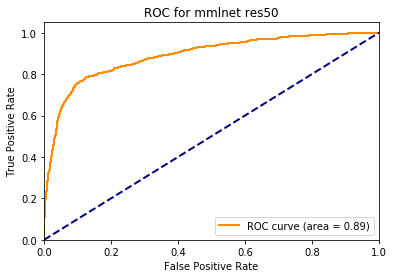

In [18]:
from sklearn import metrics

%matplotlib inline

fpr, tpr, thresholds = metrics.roc_curve(y, pred)

roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for mmlnet res50')
plt.legend(loc="lower right")
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix

threshold = 0.35

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

In [14]:
cm[0,0]/sum(cm[0,:]), cm[1,1]/sum(cm[1,:])

(0.8230353929214157, 0.8084967320261438)

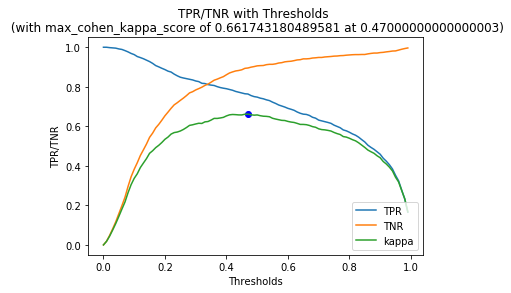

In [15]:
import numpy
from sklearn.metrics import cohen_kappa_score
mali = []
beni = []
cohen = []
tt = numpy.arange(0,1,0.01)
for thres in tt:
#     print(thres)
    pred_t = pred > thres
    pred_t.astype(int)
    cm = confusion_matrix(y,pred_t)
    mali.append(cm[1,1]/sum(cm[1,:]))
    beni.append(cm[0,0]/sum(cm[0,:]))
    cohen.append(cohen_kappa_score(y,pred_t))
# print(thresholds)
plt.figure(),plt.plot(tt,mali,label='TPR'),plt.plot(tt,beni,label='TNR'),plt.plot(tt,cohen,label='kappa')
plt.xlabel('Thresholds')
plt.ylabel('TPR/TNR')

plt.legend(loc="lower right")


net_max = cohen.index(max(cohen))
plt.title('TPR/TNR with Thresholds \n (with max_cohen_kappa_score of {} at {})'.format(max(cohen),tt[net_max]))
plt.scatter(tt[net_max], cohen[net_max], color='b')
plt.show()

In [16]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



#     plt.figure(figsize=(4, 3))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

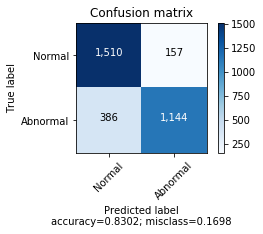

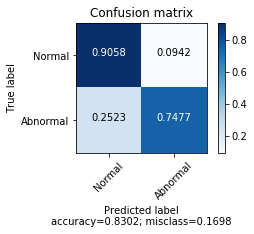

In [17]:
from sklearn.metrics import confusion_matrix

threshold = 0.5

pred_t = pred > threshold
pred_t.astype(int)

cm = confusion_matrix(y,pred_t)

plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= False)
plot_confusion_matrix(cm,('Normal','Abnormal'),normalize= True)

In [25]:
a = 0.7

In [26]:
a>0.5

True

In [28]:
1-(a>0.50)

0

In [43]:
a = torch.rand(3,3)

In [44]:
a

tensor([[0.2847, 0.4820, 0.1940],
        [0.7670, 0.0734, 0.9933],
        [0.7518, 0.1041, 0.5967]])

In [35]:
a.shape

torch.Size([3, 3])

In [36]:
b = [0,2,1]

In [37]:
b = torch.tensor(b)

In [55]:
bb = b.reshape(-1,1)

In [54]:
b

tensor([0, 2, 1])

In [39]:
l = F.nll_loss(a,b)

In [40]:
l

tensor(-0.5024)

In [46]:
sm = nn.LogSoftmax(dim=1)

In [47]:
aa = sm(a)

In [48]:
aa

tensor([[-1.1415, -0.9442, -1.2322],
        [-1.0130, -1.7066, -0.7866],
        [-0.8669, -1.5147, -1.0220]])

In [56]:
l = F.nll_loss(aa,bb)

RuntimeError: multi-target not supported at ..\aten\src\THNN/generic/ClassNLLCriterion.c:20

In [53]:
l

tensor(1.1476)

In [59]:
a = np.random.rand(3,4)

In [66]:
b = np.random.rand(2,4)

In [72]:
t = [a,b]

In [73]:
np.array(t).shape

(2,)

In [74]:
t.pop()

array([[0.255251, 0.802925, 0.39936 , 0.069087],
       [0.192725, 0.195726, 0.765414, 0.068067]])

In [75]:
t.pop()

array([[0.269292, 0.443954, 0.016551, 0.314709],
       [0.903049, 0.930926, 0.752409, 0.969705],
       [0.035113, 0.174226, 0.025869, 0.240254]])

In [76]:
t[0]

IndexError: list index out of range